# TP6: Air Traffic Control

This practical session is about a real-world problem in air traffic control, treated in 1991 in Prolog with a meta-interpreter for propagating constraints over finite domains, when your teacher was at CNRS and consultant at Thomson-CSF/Thales.

Today you are asked to use MiniZinc with finite domain constraints to model and solve this optimization problem.


## Traffic regulation on arrivals
Air traffic control in the terminal area corridors of an airport includes all arriving flights within 40 minutes of the runway. Scheduling the landing of flights is a critical task during peak periods. At an airport such as Orly, the arrivals can be regulated by delaying the departures of domestic flights to Orly, however, departure regulations do not apply to long-haul flights. 

The purpose of this TP is to show, using constraint-based modeling and optimization tools, that unnecessary delays can be avoided by optimizing the sequence of landing flights.

The constraints of the problem can be defined as follows:
* Each flight has an **expected time of arrival**, *counted in seconds from current time 0*. 
* The **actual time of arrival** that we want to compute must be located within a **strict range** (i.e. bounds excluded) determined by
** a *delay factor*, set by default to 3 times the expected time of arrival,
** and an *advance factor*, set to 0.8 by default, with respect to the expected time of arrival.

The terminal area of an airport is **divided in space** with several runway approach **corridors**.
* Each flight is assigned a corridor and can not leave it. 

The terminal area is also **divided in time** in three areas:
* the **critical area** (5 min from the landing track, 5mn included) where no permutation of flights is possible,
* the **regulated area** (5 to 20 minutes from the track, 20 mn included) where permutations between flights in different corridors only are possible,
* the **third zone** (20 to 40 min from the track) where all permutations of flights are possible even within the same air corridor.

Changes to flights are made by giving commands to the pilot who can modify the speed of the aircraft or the trajectory (either by widening a curve or by making loops), but we will not directly deal with these aspects here.

The distances to be respected between flights depend on the **size of the aircrafts**.
* There are three categories of aircrafts: A (large), B (medium), C (small).
* Because of the air turbulences created, small aircrafts behind a large aircraft need a larger distance than the opposite.
* The **matrix of safety distances**, Dij, expresses **in seconds** the minimum **strict time separation** between i and j if i precedes j, as follows:

| Dij | A |  B  | C |
| --- | --- | --- | --- |
| A | 100 | 130 | 160 |
| B | 70 | 80 |100|
| C | 60 | 60 | 70 |
 
For the sake of simplification, it will be sufficient to apply these **time separation constraints at landing time**, that is to say at the computed time of arrival, **not in all intermediate points**.

The basic strategy of the air traffic controllers essentially consists in preserving the order of the sequence of arrivals (i.e. **First-In First-Out FIFO strategy**)
* by advancing and delaying the flights in order to satisfy the time separation constraints between aircrafts. 

However, since the distance matrix is not symmetrical, it is possible to **minimize the overall time of arrival of the set of flights by permuting some flights** in the expected sequence of arrivals. The search for an optimal solution then becomes NP-difficult.

## Data from Orly Airport

The vintage image below shows a screen copy of the system developed in 1991 in Prolog with constraints for finding optimal solutions. It is shown here to help visualize both the data about the **3 air corridors** towards Orly's landing track, the expected time arrival and one optimal solution for **15 flights**:
* the track is depicted on the left, 
* the corridors are materialized by 3 horizontal bands,
* the lower part of the screen shows the initially expected time of arrival together with the solution resulting from the First-In First-Out FIFO strategy preserving the order of arrival (28.67 mn in this example). 
* the upper part shows an optimal solution of proven optimal cost 26.5 mn. This solution consists in permuting flights 6 and 7-8, 12 and 13, 14 and 15. 

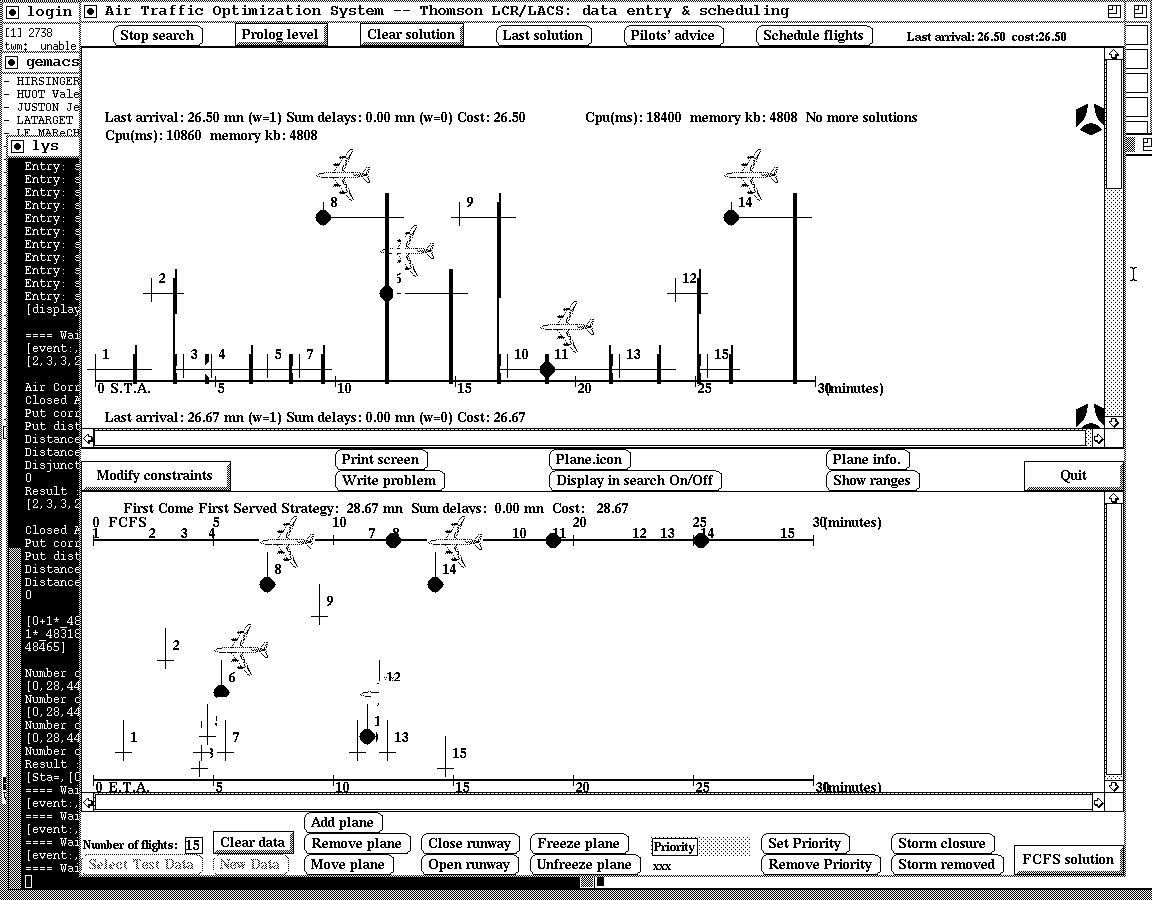

The file **ATCorly.dzn contains a data set** for
* 15 flights
* in the 3 air corridors of Orly.
In this example, 
the minimum time for landing the sequence of flights keeping the order of the sequence (FIFO strategy) is 23.58 minutes (i.e. 23mn35s)

The **ATCsydney.dzn** is another dataset of
* 20 flights
* in 3 air corridors.

In [1]:
import inf555

In [2]:
!vimcat.sh ATCorly.dzn

%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
% Data file from Orly airport
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

% The flights are assumed to be sorted by increasing order of expected arrival time

% number of flights
nf = 15; 

% number of corridors
nc = 3;

% expected time of arrival in seconds

expectedtime = [75,180,265,270,285,320,330,435,565,660,685,715,735,855,880];

% aircraft categories (A=1, B=2, C=3)

category = [2,3,3,2,3,1,3,1,2,2,1,3,2,1,3];

% aircraft corridors

corridor = [1,2,1,1,1,2,1,3,3,1,1,2,1,3,1];




In [3]:
!vimcat.sh ATCsydney.dzn

%%%%%%%%%%%%%%%%%
% Larger data set
%%%%%%%%%%%%%%%%%

% The flights are assumed to be sorted by increasing order of expected arrival time

% number of flights
nf = 20; 

% number of corridors
nc = 3;

% expected time of arrival in seconds

expectedtime = [75, 180, 265, 270, 285, 320, 330, 435, 565, 660, 685, 690, 715, 720, 735, 740, 855, 860, 880, 885];

% aircraft categories (A=1, B=2, C=3)

category = [2,3,3,2,3,1,3,1,2,2,1,3,2,1,3,2,3,3,2,3];

% aircraft corridors

corridor = [1,2,1,1,1,2,1,3,3,1,1,2,1,3,1,1,2,1,1,1];


# Question 1. MiniZinc types and variables
### Define in a file `ATC.mzn`
* the types and variables for the data of the problem
* the distance matrix
* the decision variables, i.e. the array of computed times of arrival,
* the predicates advance(i) and delay(i) that post the time range constraints with respect to the expected time of arrival of flight i
* the range constraints for all flights
* the predicate precedes(i, j) that posts the distance constraint if flight i precedes flight j 

In [4]:
!vimcat.sh ATC.mzn

int: nf;
int: nc;

set of int: CAT = 1..3;
set of int: COR = 1..nc;

array[1..nf] of int: expectedtime;
array[1..nf] of CAT: category;
array[1..nf] of COR: corridor;

array[CAT, CAT] of int: distance_matrix = [|100, 130, 160,
                                           |70, 80, 100,
                                           |60, 60, 70|];
array[1..nf] of var int: time;

constraint forall (i in 1..nf) 
    (
        (time[i] > 0.8 * expectedtime[i]) /\ 
        (time[i] < 3 * expectedtime[i])
    );

predicate precedes(var int: i, var int: j) = 
    (
        (time[j] - time[i]) > (distance_matrix[category[i], category[j]]) /\
        time[i] < time[j]
    );


# Question 2. First-In First-Out Strategy in MiniZinc
### Define in a file `ATCfifo.mzn`
* the inclusion of file ATC.mzn
* the distance constraints for the FIFO strategy
* the search using the FIFO strategy as heuristics
* the output for printing the global landing time, the solution found, and the computation time

### Execute the FIFO strategy on Orly and Sydney data
The global landing time should be 23.58mn (i.e. 23mn35s) on Orly data and 30.17mn (i.e. 30mn10s) on Sydney data 

In [5]:
!vimcat.sh ATCfifo.mzn

include "ATC.mzn";

constraint forall (i in 2..nf) (precedes(i-1, i));

solve minimize time[nf];


In [6]:
print(inf555.minizinc('ATCfifo.mzn', 'ATCorly.dzn'))

Solution(objective=1415, time=[61, 162, 233, 294, 395, 456, 617, 678, 809, 890, 961, 1122, 1183, 1254, 1415], _checker='')


In [7]:
print(inf555.minizinc('ATCfifo.mzn', 'ATCsydney.dzn'))

Solution(objective=1810, time=[61, 162, 233, 294, 395, 456, 617, 678, 809, 890, 961, 1122, 1183, 1254, 1415, 1476, 1577, 1648, 1709, 1810], _checker='')


# Question 3. Time Window Constraint Satisfiability 
Before dealing with the optimization problem, let us first deal with the problem of checking the satisfiability of the constraints of the  problem for a given sequence of fligths.

Those constraints are slightly more general than the disjunctive precedence constraints for job-shop scheduling as in the `bridge.mzn` but can be dealt with using the same techniques.

### Define in file `ATCsat.mzn`
* the critical area constraints (avoiding to post the transition closure of the precedence constraints)
* the regulated area constraints
* the third area constraints
* the search for satisfiability 

In [8]:
!vimcat.sh ATCsat.mzn

include "ATC.mzn";

array[1..nf] of var int: order;

constraint forall (i,j in 1..nf where i < j)
    (
        order[i] != order[j] /\
        order[i] <= nf /\
        order[i] >= 1
    );

constraint forall (i in 2..nf )
    (
        (time[order[i-1]] <time[order[i]] ) /\
        (precedes(order[i-1], order[i]))
    );


constraint forall (i in 1..nf )
    (
        (order[i] == i) \/
        (
            (expectedtime[i] > 300) /\
            expectedtime[order[i]] > 300 /\
            (
                ((expectedtime[i] > 1200) /\ (expectedtime[order[i]] > 1200)) \/
                (corridor[i] != corridor[order[i]])
            )
        )
    );


solve minimize max(time);


In [9]:
print(inf555.minizinc('ATCsat.mzn', 'ATCorly.dzn'))

Solution(objective=1235, order=[1, 2, 3, 4, 5, 7, 9, 6, 11, 10, 12, 15, 13, 14, 8], time=[61, 162, 233, 294, 395, 598, 466, 1235, 527, 830, 699, 931, 1063, 1134, 1002], _checker='')


In [10]:
print(inf555.minizinc('ATCsat.mzn', 'ATCsydney.dzn'))

Solution(objective=1610, order=[1, 2, 3, 4, 5, 7, 9, 10, 16, 6, 11, 8, 13, 20, 12, 17, 15, 18, 19, 14], time=[61, 162, 233, 294, 395, 760, 466, 962, 527, 608, 861, 1265, 1093, 1610, 1407, 689, 1336, 1478, 1539, 1194], _checker='')


# Question 4. Add and-choice and or-choice heuristics to implement the FIFO strategy




### Define in file `ATCsatFIFO.mzn` the FIFO search heuristics


Verify that with those and-choice (choice of first variables) and or-choice (choice of first values) heuristics you compute the same solution as when expressed with (precedence) constraints instead of heuristics



In [11]:
!vimcat.sh ATCsatFIFO.mzn

include "ATC.mzn";

constraint forall (i in 2..nf) (precedes(i-1, i));

solve:: int_search(time, input_order, indomain_min, complete) minimize time[nf];


In [12]:
print(inf555.minizinc('ATCsatFIFO.mzn', 'ATCorly.dzn'))

Solution(objective=1415, time=[61, 162, 233, 294, 395, 456, 617, 678, 809, 890, 961, 1122, 1183, 1254, 1415], _checker='')


In [13]:
print(inf555.minizinc('ATCsatFIFO.mzn', 'ATCsydney.dzn'))

Solution(objective=1810, time=[61, 162, 233, 294, 395, 456, 617, 678, 809, 890, 961, 1122, 1183, 1254, 1415, 1476, 1577, 1648, 1709, 1810], _checker='')


# Question 5. Computing an Optimal ATC Solution


### Define in a file ATCoptim.mzn
* the objective function and the search to mimize the global landing time of the flights

What is the optimal cost ?

How far was the FIFO strategy from the optimal solution ?

In [14]:
!vimcat.sh ATCoptim.mzn

include "ATC.mzn";

array[1..nf] of var int: order;

constraint forall (i,j in 1..nf where i < j)
    (
        order[i] != order[j] /\
        order[i] <= nf /\
        order[i] >= 1
    );

constraint forall (i in 2..nf )
    (
        (time[order[i-1]] <time[order[i]] ) /\
        (precedes(order[i-1], order[i]))
    );


constraint forall (i in 1..nf )
    (
        (order[i] == i) \/
        (
            (expectedtime[i] > 300) /\
            expectedtime[order[i]] > 300 /\
            (
                ((expectedtime[i] > 1200) /\ (expectedtime[order[i]] > 1200)) \/
                (corridor[i] != corridor[order[i]])
            )
        )
    );


solve minimize max(time);


In [15]:
print(inf555.minizinc('ATCoptim.mzn', 'ATCorly.dzn'))

Solution(objective=1235, order=[1, 2, 3, 4, 5, 7, 9, 6, 11, 10, 12, 15, 13, 14, 8], time=[61, 162, 233, 294, 395, 598, 466, 1235, 527, 830, 699, 931, 1063, 1134, 1002], _checker='')


In [16]:
print(inf555.minizinc('ATCoptim.mzn', 'ATCsydney.dzn'))

Solution(objective=1610, order=[1, 2, 3, 4, 5, 7, 9, 10, 16, 6, 11, 8, 13, 20, 12, 17, 15, 18, 19, 14], time=[61, 162, 233, 294, 395, 760, 466, 962, 527, 608, 861, 1265, 1093, 1610, 1407, 689, 1336, 1478, 1539, 1194], _checker='')


# Question 6: Design and Implement a Greedy Heuristics Algorithm

* Examine the swaps done in the optimal solutions compared to the FIFO strategy
* Find a heuristic criterion for determining when those swaps are good
* Use this criterions to design a (deterministic) greedy heuristic strategy better than FIFO 

Implement it in file `ATCgreedy.mzn`

In [17]:
!vimcat.sh ATCgreedy.mzn


include "ATC.mzn";


predicate pd(var int: i, var int: j) = 
    (
        (expectedtime[i] > 300) /\
        (expectedtime[j] > 300) /\
        (
            ((expectedtime[i]  > 1200) /\ (expectedtime[j] > 1200))\/
            (corridor[i] != corridor[j])
        )
    );

constraint forall (i,j in 1..nf where i < j)
    (
        if (time[i] > time[j])
        then
            (pd(i,j))/\
            (precedes(j,i))
        else
            (precedes(i,j))
        endif
    );


solve minimize max(time);


this is my first version for optimal solution but it needs too much time to run and i dont know why as it seems similar to search the order

In [ ]:
print(inf555.minizinc('ATCgreedy.mzn', 'ATCorly.dzn'))

In [ ]:
print(inf555.minizinc('ATCgreedy.mzn', 'ATCsydney.dzn'))